In [27]:
import numpy as np
import numpy.linalg as la
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import sys
import math
import inspect
import scipy as sp
from scipy import optimize
import scipy.stats as scstats

In [2]:
class ProgressBar:
    __slots__ = ['description', 'overall', 'done', 'prevp', 'len', 'closed']
    def __init__(self, description, overall):
        self.description = description
        self.overall = overall
        self.done = 0
        self.prevp = -1
        self.len = 40
        self.closed = False
        self.__show()
    def go(self):
        self.done += 1
        self.__show()
    def __show(self):
        p100 = int(round(100.0 * self.done / self.overall))
        if p100 > self.prevp:
            p = int(round(self.len * self.done / self.overall))
            print("\r%s: [%s%s] %d%%" % (self.description, '#' * p, '.' * (self.len - p), p100), end='')
            self.prevp = p100
            if p == self.len:
                self.close()
    def close(self):
        if not self.closed:
            self.closed = True
            print()


In [75]:
def InitializeDataset(name):
    dataset = pd.read_csv(name)
    return dataset.values

Dataset = InitializeDataset('chips.txt')

In [6]:
MetricCount = 3
TransformsCount = 6

__Metrics = [lambda x, y : la.norm(x - y),
           lambda x, y : la.norm(x - y, ord = 1),
           lambda x, y : la.norm(x - y, ord = np.inf)]
def QueryMetric(mInd, tInd):
    if tInd == 0:
        trans = lambda x, y: np.array([x, y])
    elif tInd == 1:
        trans = lambda x, y: np.array([x, y, x ** 2 + y ** 2])
    elif tInd == 2:
        trans = lambda x, y: np.array([x - y, x + y])
    elif tInd == 3:
        trans = lambda x, y: np.array([x, y, x ** 2, y ** 2])
    elif tInd == 4:
        trans = lambda x, y: np.array([3 * x + 2 * y, x])
    elif tInd == 5:
        trans = lambda x, y: np.array([x, y, x ** 2, y ** 2, x * y])
        #trans = lambda x, y: np.array([math.sqrt(x ** 2 + y ** 2), math.atan2(x, y)])

    def ret(x, y):
        x = trans(x[0], x[1])
        y = trans(y[0], y[1])
        return __Metrics[mInd](x, y)
    return ret


In [7]:
def GetKNearest(u, objects, k, Ro):
    values = np.apply_along_axis(lambda x : Ro(u, x[:2]), 1, objects)
    result = objects[np.argsort(values)]
    return result[:k], result[k]

In [8]:
def calculateScore(answers, predicted, showConfusion = False):
    #TODO: calculate a confusion matrix
    accuracy = False
    if (accuracy):
        sum = 0
        for i in range(0, predicted.shape[0]):
            if (answers[i] == predicted[i]):
                sum += 1
        return sum / predicted.shape[0];
    else:
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        for i in range(0, predicted.shape[0]):
            if (answers[i] == 0):
                if (predicted[i] == 0):
                    TN += 1
                else: FP += 1
            if (answers[i] == 1):
                if (predicted[i] == 0):
                    FN += 1
                else: TP += 1
        if (showConfusion):
            print ("TP = %i " % TP)
            print ("FP = %i " % FP)
            print ("TN = %i " % TN)
            print ("FN = %i " % FN)
        if (TP + FP == 0): return 0
        if (TP + FN == 0): return 0
        if (TP == 0): return 0
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        
        return 2 * precision * recall / (precision + recall)
    return 0
    
def calc_harmonic(a):
    return sum(a) / len(a)
    return len(a) / sum(1.0 / (x + 1) for x in a) - 1

In [9]:
def Partition(dataset, blockSize):
    dataset = np.copy(dataset)
    np.random.shuffle(dataset)
    ret = []
    cnt = dataset.shape[0] // blockSize
    last = 0
    for i in range(cnt):
        c = (dataset.shape[0] + i) // cnt
        ret.append(dataset[last : last + c])
        last += c
    ret = np.array(ret)
    return cnt, ret

    
def KnnClassificator(trainObjects, labelSet, metricIndex, transIndex, BlockSize = 29, T = 10):
    Ro = QueryMetric(metricIndex, transIndex)
    def Classificator(trainObjects, labelSet, k):
        def InnerClassificator(u):
            kNearest, afterKNearest = GetKNearest(u, trainObjects, k, Ro)
            labels = {label: 0 for label in labelSet}
            for object in kNearest:
                FiniteKernel = lambda x : 1 / x
                labels[object[2]] +=  1 * FiniteKernel(Ro(u, object[:2]) / (Ro(u, afterKNearest[:2])))
            return max(labels.items(), key=lambda t: t[1])[0]
        return InnerClassificator
    k = -1
    prevValue = 0
    maxK = trainObjects.shape[0] // 2;
    pbar = ProgressBar('Choose best k', maxK)
    bestScores = np.array([])
    for l in range(1, maxK + 1):
        #print("Try new k = %i:" % (l), end='')
#         curValue, allValues = 0, 0
        scores = []
        for t in range(0, T):
            q, partitions = Partition(trainObjects, BlockSize)
            for i in range(0, len(partitions)):
                training_set = []
                
                for j in range(len(partitions)):
                    if i != j:
                        training_set.extend(partitions[j])
                training_set = np.array(training_set)
                classificator = Classificator(training_set, labelSet, l)
               
                answers = np.array([])
                predicted = np.array([])
                for p in partitions[i]:
                    
                    answers = np.append(answers, p[2])
                    predicted = np.append(predicted, classificator(p[:2]))
                
                score = calculateScore(answers, predicted)
                #print(score)
                scores.append(score)
#                 curValue += score
                
#         curValue /= T * q
        #print(curValue)
#         print(T * BlockSize, allValues)
        #         print(" score = %f" % (curValue))
        curValue = calc_harmonic(scores)
        if (k == -1 or prevValue < curValue):
            k = l
            prevValue = curValue
            bestScores = scores
        pbar.go()
    pbar.close()
    print("Best k is %i with score %f" % (k, prevValue))
    return k, Classificator(trainObjects, labelSet, k), scores



In [10]:
# stdout = sys.stdout
# with open("file.txt", "w") as f:
#     #sys.stdout = f
#     for t in range(1, 4):
#         for mi in range(0, MetricCount):
#             for ti in range(0, TransformsCount):
#                 for blockSize in range(6, 15):
#                     print("with T = %i, BlockSize = %i, MetricIndex = %i, TransformIndex = %i" % 
#                         (t, blockSize, mi, ti))
#                     k, classificator, _ = KnnClassificator(Dataset, [0, 1], mi, ti, blockSize, t)
#     sys.stdout = stdout

In [11]:
 k, classificator, knnScores = KnnClassificator(Dataset, [0, 1], 1, 1, 10, 1)

Choose best k: [########################################] 100%
Best k is 9 with score 0.792124


In [12]:
points = Dataset[:, : 2]
classes = Dataset[:, 2]
h = .01
x_min, x_max = points[:, 0].min() - 0.2, points[:, 0].max() + 0.2
y_min, y_max = points[:, 1].min() - 0.2, points[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

test = np.c_[xx.ravel(), yy.ravel()]

totalCount = test.shape[0]

result = np.array([])
pbar = ProgressBar('Apply classificator', totalCount)
for x in test:
    result = np.append(result, classificator(x))
    pbar.go()
pbar.close()
result = result.reshape(xx.shape)

Apply classificator: [########################################] 100%


In [82]:
def createSVM(data, y, K, C = 1) :
    N = len(data)
    hFunc = lambda i, j: y[i] * y[j] * K(data[i], data[j])
    h = np.fromfunction(np.vectorize(hFunc), (N, N), dtype=int)
    c = C * np.ones(N)
    start = np.random.randn(N)
    cons = [ {"type": "ineq", "fun": lambda x: c - x, "jac": lambda x: -np.eye(N)}
           , {"type": "ineq", "fun": lambda x: x,                       "jac": lambda x:  np.eye(N)}
           , {"type": "eq",   "fun": lambda x: np.dot(y, x),            "jac": lambda x: y} ]
    opt = {"disp": False}
    loss = lambda x: 0.5 * np.dot(x.T, np.dot(h, x)) - np.dot(c, x)
    jac = lambda x: np.dot(x.T, h) - c
    res = sp.optimize.minimize(loss, start, jac=jac, constraints=cons, method="SLSQP", options=opt)
    w = lambda x : np.dot(res.x * y, np.apply_along_axis(lambda y : K(y, x), 1 ,data))
    
    w0 = 0
    count = 0
    for i, w_i in enumerate(res.x):
        if w_i > 0:
            w0 += w(data[i]) - y[i]
            count += 1
    if (count != 0):
        w0 /= count
    return lambda x: np.sign(w(x) - w0) * 0.5 + 0.5


In [83]:
Dataset = InitializeDataset('chips.txt')
f = lambda x : np.array([(x[0]**2 + x[1]**2) , x[0], x[1], x[0] * x[1]])
enableCV = True
np.random.shuffle(Dataset)
points = Dataset[:, : 2]
classes = Dataset[:, 2] * 2 - 1


for i in range(0, len(points)):
    t = points[i][0]
    points[i][0] = points[i][0] + points[i][1]
    points[i][1] = t - points[i][1]
c = 50
T = 1
BlockSize = 10
prevCurValue = -1
curC = 1
svmScores = None
if enableCV:
    for c in range(20, 52, 3):
        print(c)
        scores = []
        for t in range(0, T):
            q, partitions = Partition(Dataset, BlockSize)
            for i in range(0, len(partitions)):
                training_set = []

                for j in range(len(partitions)):
                    if i != j:
                        training_set.extend(partitions[j])
                training_set = np.array(training_set)

                svm = createSVM(training_set[:, :2], training_set[:, 2] * 2 - 1,lambda x, y: np.dot(f(x), f(y)), c)

                answers = np.array([])
                predicted = np.array([])
                for p in partitions[i]:

                    answers = np.append(answers, p[2])
                    predicted = np.append(predicted, svm(p[:2]))

                score = calculateScore(answers, predicted)
                #print(score)
                scores.append(score)
        #                 curValue += score

        #         curValue /= T * q
        #print(curValue)
        #         print(T * BlockSize, allValues)
        #         print(" score = %f" % (curValue))
        curValue = calc_harmonic(scores)
        if (prevCurValue < curValue):
            prevCurValue = curValue
            print("New score = %f" % curValue)
            curC = c
            svmScores = scores

    curValue = prevCurValue

    print("score %f" % curValue)





20
New score = 0.780123
23
26
29
32
35
38
41
New score = 0.787628
44
47
50
score 0.787628


In [79]:
h = .01
x_min, x_max = points[:, 0].min() - 0.2, points[:, 0].max() + 0.2
y_min, y_max = points[:, 1].min() - 0.2, points[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

test = np.c_[xx.ravel(), yy.ravel()]

totalCount = test.shape[0]

svm = createSVM(points, classes, lambda x, y: np.dot(f(x), f(y)), c)
predicted = np.array([])
for p in points:
    predicted = np.append(predicted, svm(p))
print("score %f" % calculateScore(predicted, Dataset[:, 2], True))

print("KNN mean score: %.3f" % (sum(knnScores) / len(knnScores)))
print("SVM mean score: %.3f" % (sum(svmScores) / len(svmScores)))

def calcWilcoxon(knn, svm):
    all = list(set(knn + svm))
    all.sort()
    val = {x : i / (len(all) - 1) for i, x in enumerate(all)}
    return sum(val[x] for x in knn), sum(val[x] for x in svm)

print("Wilcoxon = %f, %f" % calcWilcoxon(knnScores, svmScores))

print("Lens are: %d and %d" % (len(knnScores), len(svmScores)))

print(scstats.wilcoxon(knnScores, svmScores))


result = np.array([])
pbar = ProgressBar('Apply classificator', totalCount)
for x in test:
    result = np.append(result, svm(x))
    pbar.go()
pbar.close()
result = result.reshape(xx.shape)





TP = 46 
FP = 12 
TN = 49 
FN = 11 
score 0.800000
KNN mean score: 0.741
SVM mean score: 0.803
Wilcoxon = 4.846154, 7.230769
Lens are: 11 and 11
WilcoxonResult(statistic=13.0, pvalue=0.075368238689472483)
Apply classificator: [########################################] 100%


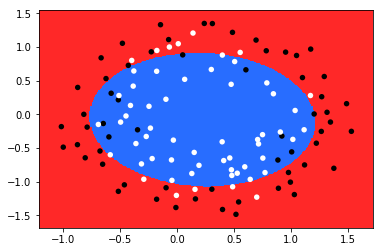

In [80]:
cmap_light = ListedColormap(['#ff2828', '#286dff'])
# cmap_bold = ListedColormap(['#a50000', '#0c00a5'])
cmap_bold = ListedColormap(['#000000', '#ffffff'])
plt.figure()
plt.rcParams["figure.figsize"] = list(map(lambda x: x * 1, plt.rcParams["figure.figsize"]))
plt.pcolormesh(xx, yy, result, cmap=cmap_light)
plt.scatter(points[:, 0], points[:, 1],  c = classes,cmap=cmap_bold,linewidths=0, s=30)


plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()